# Case: Hospital with roles

#### Imports

In [1]:
# using Pkg
# Pkg.add("CSV")
# Pkg.add("DataFrames")
# Pkg.add("Random")
# Pkg.add("Statistics")
# Pkg.add("Dates")
# Pkg.add("Gurobi")
# Pkg.add("JuMP")
# Pkg.add("Plots")
# Pkg.add("LinearAlgebra")
using CSV, DataFrames, Random, Statistics, Dates, Gurobi, JuMP, Plots, LinearAlgebra;

#### Functions

In [2]:
function display_work_schedule(i)
    role_names = ["Doctor", "Nurse", "Assistant"]
    active(row) = any([row[:Doctor] > 0, row[:Nurse] > 0, row[:Assistant] > 0])
    personal_shifts = hcat(shifts, DataFrame(X_opt[i,:,:],role_names))
    active_shifts = filter(active, personal_shifts)
    display(active_shifts)
    calendar = transpose(reshape(sum(Matrix(personal_shifts[:, role_names]), dims=2),21,:)) # 21 x 4 matrix of 3 values per day
    calendar_flipped = reverse(calendar, dims=1)
    labels = repeat(weekdays, 1, ceil(Int, size(calendar, 2) / length(weekdays)))
    heatmap(calendar_flipped, color=:viridis, aspect_ratio=:equal, size=(1200,400), 
        xticks=(2:3:21, weekdays), yticks=(1:4,["Week4", "Week3", "Week2", "Week1"]), title="January Work schedule for "*employees.name[i])
    vline_positions = 3.5:3:20.5
    vline!(vline_positions, linestyle=:dash, linecolor=:black, linewidth=2, label=false)
end;

### Shift data

In [3]:
hours_in_month = 8*5*4
num_days = 28
start_dates = [Date(2024, 1, 1) + Day(i-1) for i in 1:num_days]
start_times = [Time(7,0), Time(15,0), Time(23,0) ]
shift_durations = [8, 10, 12]

shifts = DataFrame(date = Date[], start_time = Time[], duration = Float64[], weekday = String[])

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
i = 1
j = 1
Random.seed!(42)
for start_date in start_dates, start_time in start_times
    if i == 8
        i = 1
    end
    push!(shifts, (start_date, start_time, rand(shift_durations), weekdays[i]))
    if mod(j,3) == 0
        i += 1
    end
    j += 1
end
first(shifts,10)

Row,date,start_time,duration,weekday
,Date,Time,Float64,String
1,2024-01-01,07:00:00,10.0,Monday
2,2024-01-01,15:00:00,10.0,Monday
3,2024-01-01,23:00:00,10.0,Monday
4,2024-01-02,07:00:00,12.0,Tuesday
5,2024-01-02,15:00:00,12.0,Tuesday
6,2024-01-02,23:00:00,8.0,Tuesday
7,2024-01-03,07:00:00,10.0,Wednesday
8,2024-01-03,15:00:00,12.0,Wednesday
9,2024-01-03,23:00:00,10.0,Wednesday


### Shift-roles data

In [4]:
S = shifts[!,1:2]
m = nrow(shifts)

Random.seed!(1)
# Roles needed for each shift
shift_roles = DataFrame(Nurses=[5+rand([0,0,0,0,1])*rand([1,-1]) for _ in 1:m], 
    Doctors=[3+rand([0,0,0,0,1,1,2])*rand([1,-1]) for _ in 1:m], 
    Assistants=[3 for _ in 1:m])
first(shift_roles,5)

Row,Nurses,Doctors,Assistants
,Int64,Int64,Int64
1,5,3,3
2,5,4,3
3,6,3,3
4,5,2,3
5,5,3,3


### Empoyee-role data

In [9]:
country_names = CSV.read("data/countries.csv", DataFrame, header=false)
Random.seed!(42)
shuffle!(country_names)
FTE_rates = vcat(fill(1.0, 50), fill(0.75, 26), fill(0.7, 16), fill(0.5, 18))
id = 1:length(FTE_rates)
employees = DataFrame(id = id, name = country_names[1:length(id),1], FTE_rate = FTE_rates)

n = nrow(employees)
num_doctors = round(Int, n * 0.25)
num_assistants = round(Int, n * 0.25)
num_nurses = n - num_doctors - num_assistants
roles = vcat(fill("Nurse", num_nurses), fill("Doctor", num_doctors), fill("Assistant", num_assistants))
Random.seed!(42)
shuffle!(roles)

employees.main_role = roles

emp_role = DataFrame(Doctor = Int[], Nurse = Int[], Assistant = Int[])
for role in roles
    doctor = 0
    nurse = 0
    assistant = 1 # All doctors and nurses are assistants
    if role == "Doctor"
        doctor = 1
        nurse = 1 # All doctors are nurses
    elseif role == "Nurse"
        nurse = 1 
    end
    push!(emp_role, (doctor, nurse, assistant))
end
first(emp_role,10)

Row,Doctor,Nurse,Assistant
,Int64,Int64,Int64
1,0,1,1
2,1,1,1
3,0,1,1
4,0,0,1
5,0,0,1
6,0,1,1
7,1,1,1
8,0,1,1
9,1,1,1


### Employee data

In [10]:
Random.seed!(42)
wages = [round(dot(row,[20,15,15])*(1+rand()/10*rand([1,1,1,1,0])), digits=1) for row in eachrow(emp_role)]

employees.wage = wages
first(shuffle(employees),10)

Row,id,name,FTE_rate,main_role,wage
,Int64,String,Float64,String,Float64
1,77,Switzerland,0.7,Nurse,33.0
2,4,Estonia,1.0,Assistant,15.9
3,5,Suriname,1.0,Assistant,15.7
4,32,Tuvalu,1.0,Doctor,50.0
5,39,Comoros,1.0,Doctor,50.5
6,2,Cote d'Ivoire,1.0,Doctor,52.4
7,76,Russia,0.75,Doctor,52.6
8,104,Anguilla,0.5,Assistant,16.1
9,94,Nicaragua,0.5,Nurse,32.2


### Availability data

In [11]:
A = ones(n, m)

A[3,1:15] = zeros(15)
A[10,10] = 0
A[13,36:48] = zeros(13);

# Optimization

In [12]:
# D = shifts[!,"required_workers"]
D = shift_roles
L = shifts[!,"duration"]
S = employees[!,"wage"]
FTE = employees[!,"FTE_rate"]
R = emp_role
epsilon = 0.1

n = nrow(employees)
m = nrow(shifts)
l = ncol(emp_role)

model = Model(Gurobi.Optimizer)
@variable(model, Z[1:n], Bin) # Binary variable whether employee p should be included in schedule or not
@variable(model, X[1:n, 1:m, 1:l], Bin) # Whether person p is working shift s
@objective(model, Min, sum(sum(sum(X[p,s,r]*L[s]*S[p] for r in 1:l) for s in 1:m) for p in 1:n) + 4000*sum(Z)) # Total cost of shift-schedule
@constraint(model, zx_constraint[p in 1:n, s in 1:m, r in 1:l], X[p,s,r] <= Z[p]) # Person p can only get assigned if they are included in schedule
@constraint(model, demand_constraint[s in 1:m, r in 1:l], sum(X[p,s,r] for p in 1:n) >= D[s,r]) # each shift needs required number of employees in each role
@constraint(model, skill_constraint[p in 1:n, s in 1:m, r in 1:l], X[p,s,r] <= R[p,r]) # Person p cannot complete a role they are not educated to perform
@constraint(model, one_emp_per_shift_constraint[p in 1:n, s in 1:m], sum(X[p,s,r] for r in 1:l) <= 1)
@constraint(model, FTE_lower_constraint[p in 1:n], sum(sum(X[p,s,r]*L[s] for r in 1:l) for s in 1:m) >= FTE[p]*hours_in_month*(1-epsilon)*Z[p]) # each employee's FTE rate should be almost met
@constraint(model, FTE_upper_constraint[p in 1:n], sum(sum(X[p,s,r]*L[s] for r in 1:l) for s in 1:m) <= FTE[p]*hours_in_month*(1+epsilon)*Z[p])
@constraint(model, availability_constraint[p in 1:n, s in 1:m, r in 1:l], X[p,s,r] <= A[p,s]) # only available employees are assigned to shifts
@constraint(model, consecutive_shifts_constraint[p in 1:n, s in 1:(m-2), r in 1:l], X[p,s,r] + X[p,s+1,r] + X[p,s+2,r]<= 1)
optimize!(model);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-07
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 119932 rows, 27830 columns and 303160 nonzeros
Model fingerprint: 0xbc2c07b4
Variable types: 0 continuous, 27830 integer (27830 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+02, 4e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 94640 rows and 9311 columns
Presolve time: 0.36s
Presolved: 25292 rows, 18519 columns, 150205 nonzeros
Variable types: 0 continuous, 18519 integer (18519 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 5.520490e+0

In [14]:
X_opt = value.(X)
employees.nr_shifts = sum(sum(X_opt, dims=3)[:,:,1], dims=2) |> vec
employees.hours = sum(X_opt, dims=3)[:,:,1]*L;
first(employees,8)

Row,id,name,FTE_rate,main_role,wage,nr_shifts,hours
,Int64,String,Float64,String,Float64,Float64,Float64
1,1,Saint Lucia,1.0,Nurse,31.9,0.0,0.0
2,2,Cote d'Ivoire,1.0,Doctor,52.4,18.0,176.0
3,3,Morocco,1.0,Nurse,32.0,0.0,0.0
4,4,Estonia,1.0,Assistant,15.9,17.0,176.0
5,5,Suriname,1.0,Assistant,15.7,17.0,176.0
6,6,British Virgin Is.,1.0,Nurse,32.0,0.0,0.0
7,7,Samoa,1.0,Doctor,51.7,19.0,176.0
8,8,Gibraltar,1.0,Nurse,31.5,18.0,176.0


### Full workforce and unused employees

In [15]:
employees[employees.hours .> 0, :]

Row,id,name,FTE_rate,main_role,wage,nr_shifts,hours
,Int64,String,Float64,String,Float64,Float64,Float64
1,2,Cote d'Ivoire,1.0,Doctor,52.4,18.0,176.0
2,4,Estonia,1.0,Assistant,15.9,17.0,176.0
3,5,Suriname,1.0,Assistant,15.7,17.0,176.0
4,7,Samoa,1.0,Doctor,51.7,19.0,176.0
5,8,Gibraltar,1.0,Nurse,31.5,18.0,176.0
6,9,Andorra,1.0,Doctor,51.4,17.0,176.0
7,10,Ethiopia,1.0,Nurse,31.3,18.0,176.0
8,11,Guadeloupe,1.0,Nurse,30.2,17.0,174.0
9,12,Namibia,1.0,Nurse,30.6,17.0,176.0


Employee


Row,id,name,FTE_rate,main_role,wage,nr_shifts,hours
,Int64,String,Float64,String,Float64,Float64,Float64
1,1,Saint Lucia,1.0,Nurse,31.9,0.0,0.0
2,3,Morocco,1.0,Nurse,32.0,0.0,0.0
3,6,British Virgin Is.,1.0,Nurse,32.0,0.0,0.0
4,17,Austria,1.0,Nurse,32.2,0.0,0.0
5,22,Netherlands Antilles,1.0,Nurse,32.6,0.0,0.0
6,25,Romania,1.0,Nurse,32.3,0.0,0.0
7,27,Palau,1.0,Nurse,31.6,0.0,0.0
8,30,Guernsey,1.0,Nurse,32.9,0.0,0.0
9,31,Bosnia & Herzegovina,1.0,Nurse,32.0,0.0,0.0


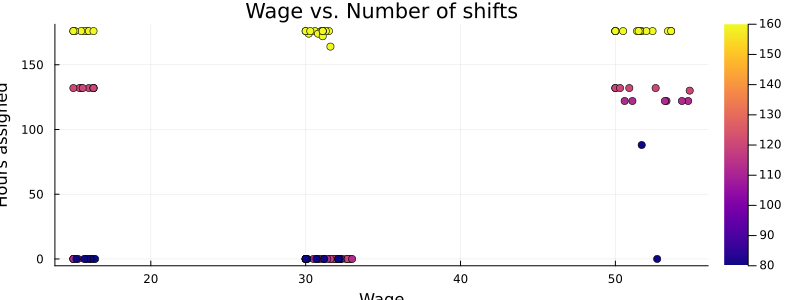

In [16]:
println("Employee")
display(employees[employees.hours .== 0, :])
scatter(employees.wage, employees.hours, title="Wage vs. Number of shifts", 
    xlabel="Wage", ylabel="Hours assigned", legend=false, marker_z=employees.FTE_rate*hours_in_month, 
    colorbar=true, cmap=:plasma, size=(800,300))

### How many employees perform roles considered below their skill level?

In [ ]:
assigned = dropdims(sum(X_opt, dims=2),dims=2)
bar(assigned,xlabel="Employee number", stacked=true, legend=:topright, size=(1000,300), label=["Doctor" "Nurse" "Assistant"])

In [ ]:
employees = hcat(employees, DataFrame(assigned, ["Doctor", "Nurse", "Assistant"]))
count_nonzeros(row) = sum([value != 0 for value in row])
employees[map(row -> count_nonzeros(row), eachrow(employees[:,[:Doctor, :Nurse, :Assistant]])) .> 1, :]

### How does an employee's schedule look?

Albania (2) is the most busy employee (most shifts).

In [ ]:
display_work_schedule(2)

Number of morning, evening and night shifts per person

### Total workforce

In [ ]:
# X_opt
employees